In [1]:
from __future__ import division

# standard imports
import numpy as np
from numpy import pi
from scipy.sparse import linalg as lag

# for plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.rc('text', usetex = True)

# kwant
import kwant

# Simple Namespace
class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)  

In [2]:
from tinyarray import array as ta
from numpy import kron

# Pauli matrices
sigma0 = ta([[1, 0], [0, 1]])
sigma1 = ta([[0, 1], [1, 0]])
sigma2 = ta([[0, -1j], [1j, 0]])
sigma3 = ta([[1, 0], [0, -1]])

# products of Pauli matrices
s0s0 = kron( sigma0,sigma0 )
s0s1 = kron( sigma0,sigma1 )
s0s2 = kron( sigma0,sigma2 )
s0s3 = kron( sigma0,sigma3 )

s1s0 = kron( sigma1,sigma0 )
s1s1 = kron( sigma1,sigma1 )
s1s2 = kron( sigma1,sigma2 )
s1s3 = kron( sigma1,sigma3 )

s2s0 = kron( sigma2,sigma0 )
s2s1 = kron( sigma2,sigma1 )
s2s2 = kron( sigma2,sigma2 )
s2s3 = kron( sigma2,sigma3 )

s3s0 = kron( sigma3,sigma0 )
s3s1 = kron( sigma3,sigma1 )
s3s2 = kron( sigma3,sigma2 )
s3s3 = kron( sigma3,sigma3 )

In [3]:
def onsite( site,p ):
    # for magnetic field in z-direction, Landau gauge
    x,=site.pos
    kyp = p.ky - float(x-p.x_shift)*float(p.lBinv2)
    
    return   p.tp*np.sin(kyp)*s3s2 + p.tzp*np.sin(p.kz)*s3s3 \
             + ( p.M0+p.t+p.t*(1-np.cos(kyp))+p.tz*(1-np.cos(p.kz)))*s1s0 \
             + p.b0/2.*s3s0 + p.betaz/2.*s0s3 - p.mu_W*s0s0


def hop( s1,s2,p ):
    return - 0.5j*p.tp*s3s1 - 0.5*p.t*s1s0

In [4]:
wx_wsm = 150

# lattices
lat = kwant.lattice.general( ( (1,), ) )

# builder
sys = kwant.Builder()

# first, define all sites and their onsite energies
for nx in range(wx_wsm):
    sys[lat(nx,)]=onsite
    
# hoppings
for nx in range(wx_wsm-1):
    sys[lat(nx+1,),lat(nx,)]=hop
    
# finalize the system
fsys = sys.finalized()

TypeError: unorderable types: tinyarray.ndarray_int() < tinyarray.ndarray_int()

In [6]:
p = SimpleNamespace( tp=2., t=2., tzp=1., tz=1., M0=-0.3, mu_W=10**(-4), \
                     betaz=1.2, b0=0.2, \
                     lBinv2=0*1./20.**2, x_shift=(wx_wsm-1.)/2., \
                     ky=.01, kz=0 )

kzs = np.linspace(-1,1,131)

ens=[]
for kz in kzs:
    p.kz=kz
    ham_sparse_coo = fsys.hamiltonian_submatrix( args=([p]),sparse=True )
    ham_sparse = ham_sparse_coo.tocsc()
    evals = lag.eigsh( ham_sparse,k=20,return_eigenvectors=False,which='LM',sigma=0, tol=10**(-3) )
    ens.append(evals)
    
kzs1,ens1=kzs,ens

In [7]:
p = SimpleNamespace( tp=2., t=2., tzp=1., tz=1., M0=-0.3, mu_W=10**(-4), \
                     betaz=1.2, b0=0.2, \
                     lBinv2=1./20.**2, x_shift=(wx_wsm-1.)/2., \
                     ky=.01, kz=0 )

kzs = np.linspace(-1,1,131)

ens=[]
for kz in kzs:
    p.kz=kz
    ham_sparse_coo = fsys.hamiltonian_submatrix( args=([p]),sparse=True )
    ham_sparse = ham_sparse_coo.tocsc()
    evals = lag.eigsh( ham_sparse,k=20,return_eigenvectors=False,which='LM',sigma=0, tol=10**(-3) )
    ens.append(evals)
    
kzs2,ens2=kzs,ens

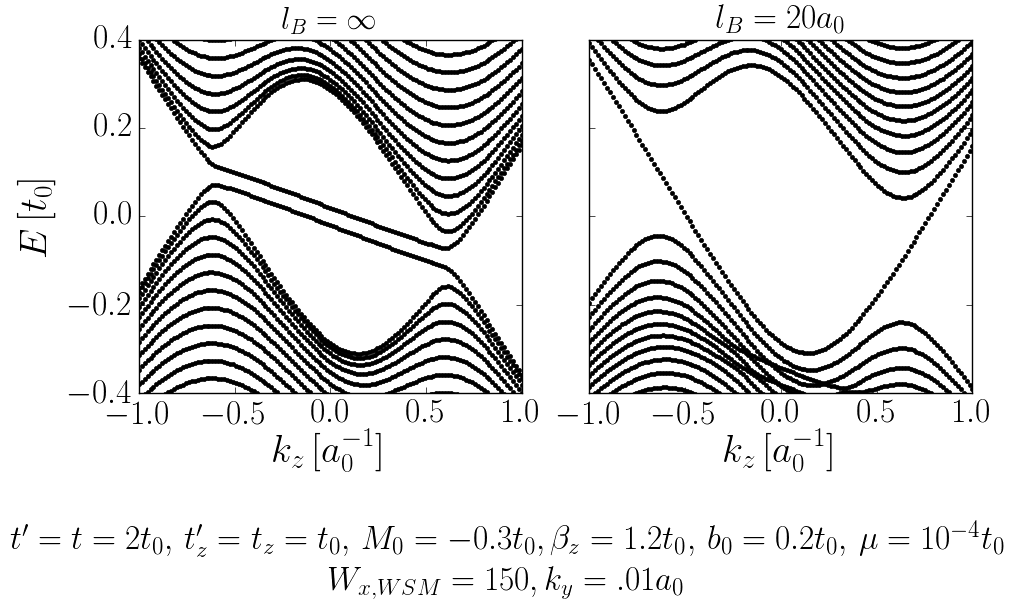

In [8]:
fig, (ax11,ax12) = plt.subplots(1,2,sharey=True,figsize=(10,5) )

_=ax11.plot(kzs1,ens1,"k.")
_=ax12.plot(kzs2,ens2,"k.")

for ax in [ax11,ax12]:
    for tl in ax.get_xticklabels():
        tl.set_color('k')
        tl.set_size( 24 )
    for tl in ax.get_yticklabels():
        tl.set_color('k')
        tl.set_size( 24 )
    ax.set_xlim(-1,1)
    ax.set_ylim(-.4,.4)
    ax.set_xlabel(r'$k_z\,[a_0^{-1}]$', color='k', fontsize=28)
    ax.locator_params(axis='x',nbins=5)
    ax.locator_params(axis='y',nbins=5)
    
ax11.set_ylabel(r'$E\,[t_0]$', color='k', fontsize=28)

ax11.set_title( r'$l_B=\infty$', fontsize=22)
ax12.set_title( r'$l_B=20 a_0$', fontsize=24)

_ = fig.text(.5, -.2, r"$t'=t=2t_0,\, t_z'=t_z=t_0,\, M_0=-0.3t_0,\,$"
               + r"$\beta_z=1.2 t_0,\, b_0=0.2 t_0,\, \mu=10^{-4} t_0$" + "\n"
               + r"$W_{x,WSM}=150, k_y=.01 a_0$"
             , horizontalalignment='center', fontsize=24, transform = ax11.transAxes);

fig.tight_layout()
#fig.savefig( "test.pdf", bbox_inches='tight')